### The NCEAS dataset has a different coordinate system than the regular one, as well as a shift applied to it, probably for anonimisation. This notebooks tries to get standard coordinates out of it.

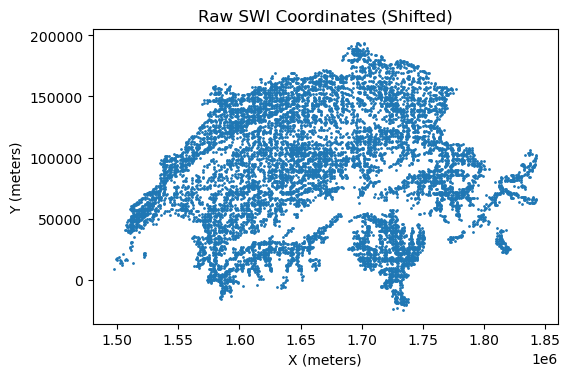

In [6]:
from pyproj import Transformer
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
import pandas as pd
env_path="embeddings_data_and_dictionaries/data_SDM_NCEAS/SWItest_env.csv"

np.set_printoptions(threshold=np.inf)      # print entire array, no truncation
np.set_printoptions(linewidth=np.inf) 

env=pd.read_csv(env_path)
#lats, lons = coord_trans(env["x"].values, env["y"].values)





plt.figure(figsize=(6, 10))
plt.scatter(env["x"], env["y"], s=1)
plt.gca().set_aspect('equal', 'box')
plt.title("Raw SWI Coordinates (Shifted)")
plt.xlabel("X (meters)")
plt.ylabel("Y (meters)")
plt.show()

shifted minimum x: 1497037.5
shifted minimum y: -25062.5
actual minimum x: 485410.0090516365
actual minimum y: 75263.6477937577
1011627.4909483634 -100326.1477937577


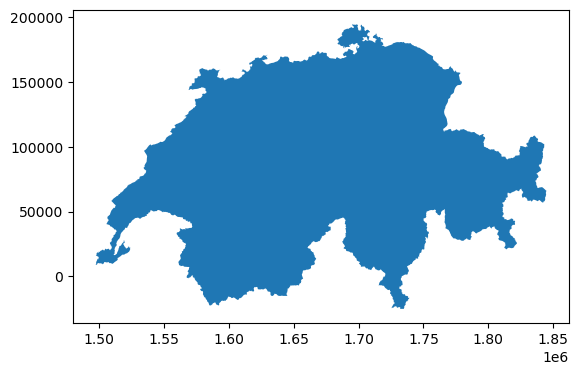

In [ ]:
import utils
import importlib
importlib.reload(utils)
import geopandas as gpd

border_file="embeddings_data_and_dictionaries/data_SDM_NCEAS/Borders/swi.gpkg"
borders=gpd.read_file(border_file)
minx, miny, maxx, maxy = borders.total_bounds

print("shifted minimum x:", minx)
print("shifted minimum y:", miny)
borders.plot()

#46.132366, 5.955899    Minimizing west point
#45.817921, 9.017064    Minimizing south point

from pyproj import Transformer

# def coord_trans(x, y, order="CH_to_normal"):

#     if order == "CH_to_normal":
#         transformer = Transformer.from_crs("EPSG:21781", "EPSG:4326", always_xy=True)
#         x_out, y_out = transformer.transform(x, y)  # X=Easting, Y=Northing
#     elif order == "normal_to_CH":
#         transformer = Transformer.from_crs("EPSG:4326", "EPSG:21781", always_xy=True)
#         x_out, y_out = transformer.transform(x, y)  # X=Longitude, Y=Latitude
#     else:
#         raise ValueError("order must be either 'CH_to_normal' or 'normal_to_CH'")
#     return x_out, y_out


We_min=utils.coord_trans(5.955899 ,46.132366 , order="normal_to_CH") #coords from google maps: First longitude! always x,y
So_min=utils.coord_trans(9.017064, 45.817921,order="normal_to_CH")
print("actual minimum x:", We_min[0])
print("actual minimum y:", So_min[1])
shift_x=minx-We_min[0]
shift_y=miny-So_min[1]
print(shift_x, shift_y)


In [35]:
#Test: we get the coords of the extremal points to compare with google maps



lons, lats = utils.coord_trans_shift(env["x"].values, env["y"].values,order="CH_to_normal")

print(lons.shape)

idx_east = np.argmax(lons)   # index of the maximum longitude
lat_east = lats[idx_east]
lon_east = lons[idx_east]
print(lat_east, lon_east)

idx_west = np.argmin(lons)   # index of the maximum longitude
lat_west = lats[idx_west]
lon_west = lons[idx_west]
print("western point (in the env file):",  lat_west,lon_west)


idx_north = np.argmax(lats) 
lat_north = lats[idx_north]
lon_north = lons[idx_north]
print("north", lat_north, lon_north)

print(lat_east, lon_east) #eastern point fall 200m beyond the border...

(10013,)
46.93122884990335 10.478264232314903
western point (in the env file): 46.125218349528666 5.956255309022179
north 47.79357289591077 8.565322361150569
46.93122884990335 10.478264232314903


northern point POINT (1844837.5 66137.5)
eastern point POINT (1695437.5 194737.5)


/tmp/ipykernel_3257213/1863214397.py:9: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  boundary = borders.boundary.unary_union  # Merge all boundaries


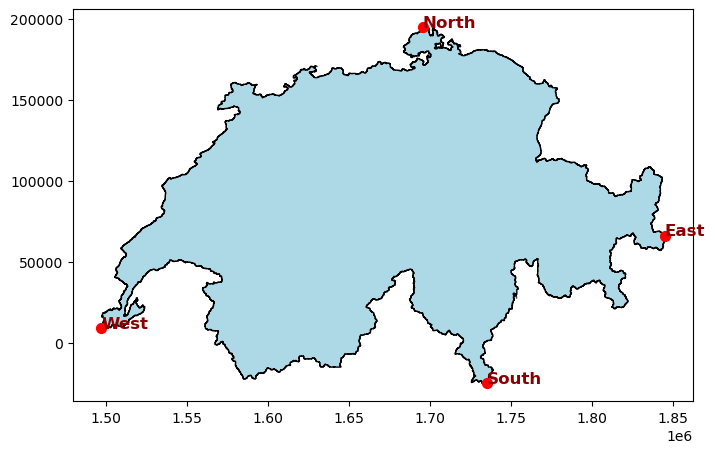

In [28]:
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import Point

# Load Switzerland borders
borders = gpd.read_file("embeddings_data_and_dictionaries/data_SDM_NCEAS/Borders/swi.gpkg")

# Get the boundary as a LineString (or MultiLineString)
boundary = borders.boundary.unary_union  # Merge all boundaries

# Extract extremal points
minx_point = maxx_point = miny_point = maxy_point = None
minx_val = float('inf')
maxx_val = -float('inf')
miny_val = float('inf')
maxy_val = -float('inf')

# Iterate over all points in the boundary
for geom in boundary.geoms if hasattr(boundary, 'geoms') else [boundary]:
    for x, y in geom.coords:
        if x < minx_val:
            minx_val = x
            minx_point = Point(x, y)
        if x > maxx_val:
            maxx_val = x
            maxx_point = Point(x, y)
            
        if y < miny_val:
            miny_val = y
            miny_point = Point(x, y)
        if y > maxy_val:
            maxy_val = y
            maxy_point = Point(x, y)
print("northern point",maxx_point)           
print("eastern point",maxy_point)
# Combine into GeoDataFrame
extremal_points = gpd.GeoDataFrame(
    geometry=[minx_point, maxx_point, miny_point, maxy_point],
    crs=borders.crs
)

# Plot
ax = borders.plot(color='lightblue', edgecolor='black', figsize=(8,6))
extremal_points.plot(ax=ax, color='red', markersize=50)

# Optional: label the points
labels = ['West', 'East', 'South', 'North']
for point, label in zip(extremal_points.geometry, labels):
    plt.text(point.x, point.y, label, fontsize=12, fontweight='bold', color='darkred')

plt.show()


In [34]:
import utils
x = minx_point.x #western point
y = minx_point.y 
print(x,y)
lon, lat= utils.coord_trans_shift(x,y, "CH_to_normal")
print([lat, lon])

southern=utils.coord_trans_shift(miny_point.x, miny_point.y, "CH_to_normal")
print(southern)

1497037.5 8937.5
[46.12510379768285, 5.95609668350229]
(9.02380475785686, 45.81782594778115)


Result: 46.12510379768285, 5.95609668350229
the actual point is 5.955899 ,46.132366 ... about 1km off

In [ ]:
#Going back and fourth keeps about 6 decimal places
lat=46.12510379768285
lon=5.95609668350229
x,y= utils.coord_trans_shift(lon,lat, "normal_to_CH")
utils.coord_trans_shift(x,y, "CH_to_normal")

(5.956096689384597, 46.12510380792114)

Index(['featurecla', 'scalerank', 'LABELRANK', 'SOVEREIGNT', 'SOV_A3',
       'ADM0_DIF', 'LEVEL', 'TYPE', 'TLC', 'ADMIN',
       ...
       'FCLASS_TR', 'FCLASS_ID', 'FCLASS_PL', 'FCLASS_GR', 'FCLASS_IT',
       'FCLASS_NL', 'FCLASS_SE', 'FCLASS_BD', 'FCLASS_UA', 'geometry'],
      dtype='object', length=169)


<Axes: >

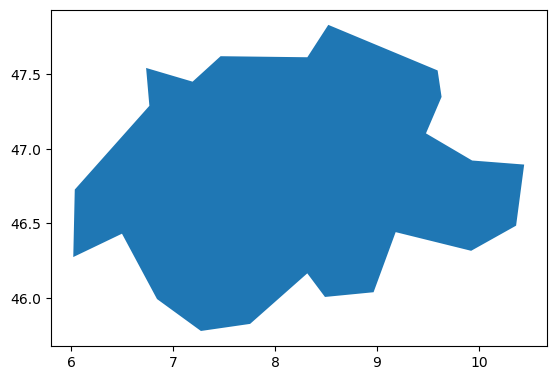

In [9]:
#inal test: plot on map:

boundaries = gpd.read_file("data_SDM_NCEAS/borders_natural_earth/ne_110m_admin_0_countries.shp")
#boundaries.plot() 
print(boundaries.columns) 
switzerland = boundaries[boundaries['NAME'] == 'Switzerland'] 
switzerland.plot()

The following should be launched with "geopandas3". It is very independent from the first part of the document, that was mostly focused around getting the coordinates right. 
Here we plot the principal components of PCA of the embeddings over maps.

In [ ]:
#Model, dataloader
from sklearn.decomposition import IncrementalPCA
import numpy as np
import importlib
import utils
import nn_classes
from tqdm import tqdm
import torch
import torch.nn as nn
import joblib
importlib.reload(utils)
importlib.reload(nn_classes)
device="cuda"
batch_size=4096
save_name="save_14_to_17-10-25"
data_path="embeddings_data_and_dictionaries/bioCLIP_full_dataset_embeddings.h5"


dataloader, _ =utils.dataloader_emb(data_path,batch_size=batch_size)
#hyperparameters:
#pos. layer sizes
#we first upscale from 2 to dim_fourrier_encoding, with the fourrier encodding
dim_fourier_encoding=64 #multiple of 4!!
dim_hidden=256
dim_emb=128 #this one is actually shared with img embeddings

#dim image layer size: 
#As of now: linear from 768 to dim_emb. We could also have MLP if non-linearity needed


image_encoder=nn.Linear(768,dim_emb).to(device)
pos_encoder=nn_classes.Fourier_MLP(original_dim=2, fourier_dim=dim_fourier_encoding, hidden_dim=dim_hidden, output_dim=dim_emb).to(device)
model= nn_classes.DoubleNetwork(image_encoder,pos_encoder).to(device)
model.load_state_dict(torch.load("Models/save_14_to_17-10-25/model.pt", weights_only=True))
pos_enc_DINO=model.pos_encoder

############other model: basic bioclip

dim_fourier_encoding=64 #multiple of 4!!
dim_hidden=256
dim_emb=128 #this one is actually shared with img embeddings
pos_encoder= nn_classes.Fourier_MLP(original_dim=2, fourier_dim=dim_fourier_encoding, hidden_dim=dim_hidden, output_dim=dim_emb)
model= nn_classes.DoubleNetwork_V2(pos_encoder,dim_hidden=768,dim_output=dim_emb).to(device)
model.load_state_dict(torch.load("Models/small_pos_enc_bioCLIP/model.pt", weights_only=True))
pos_enc_bioCLIP=model.pos_encoder
########################### bioclip hig freauencies only

/home/adam/anaconda3/envs/bioCLIP/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


(48831, 2)


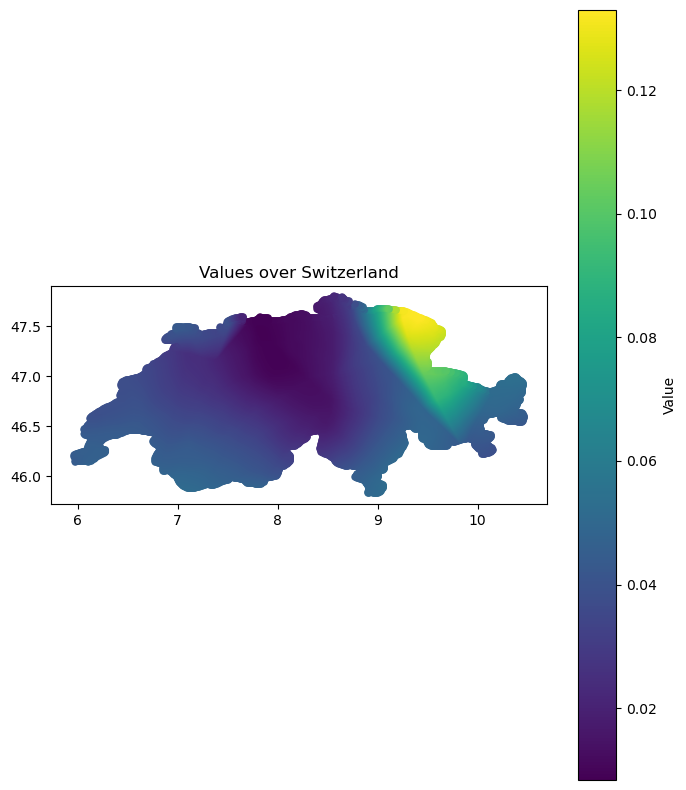

(48831, 2)


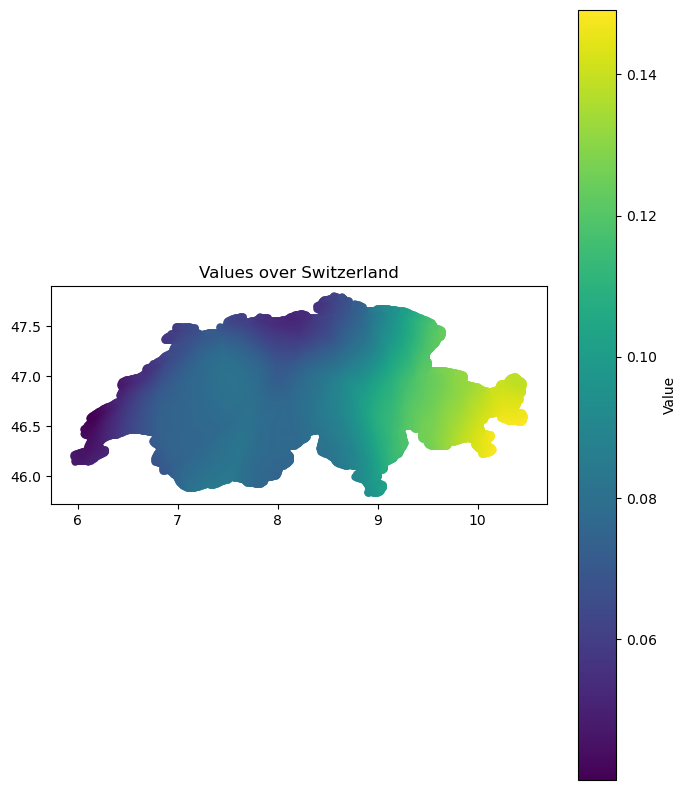

(48831, 2)


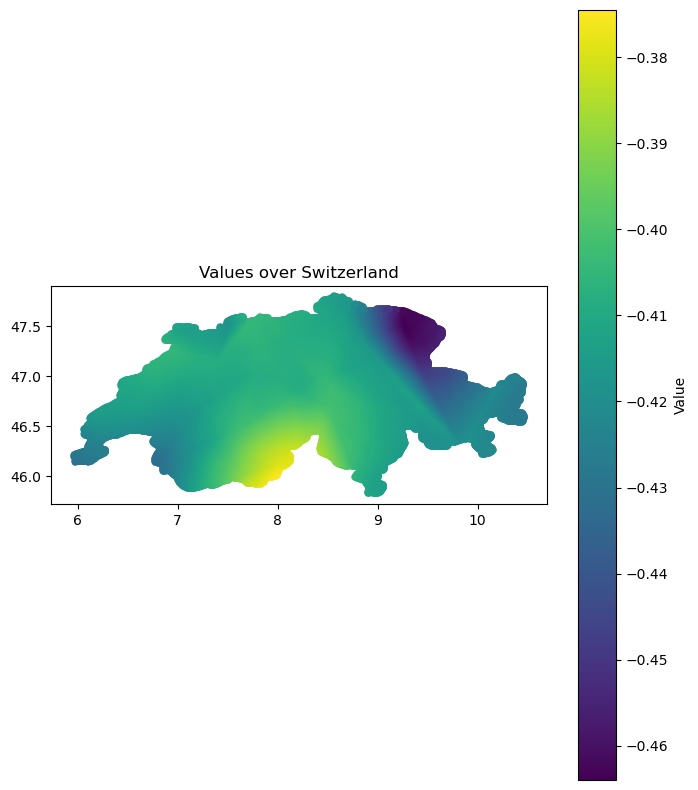

(48831, 2)


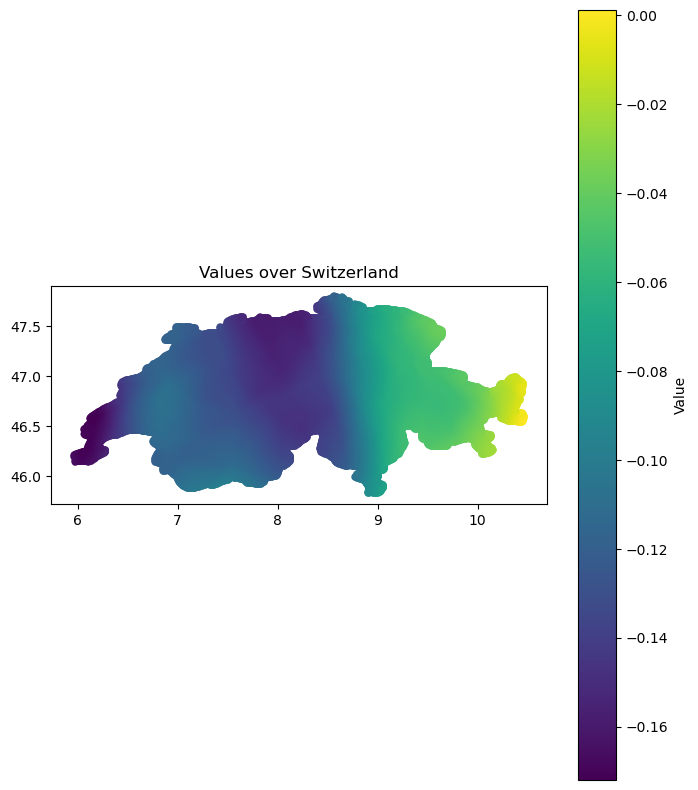

(48831, 2)


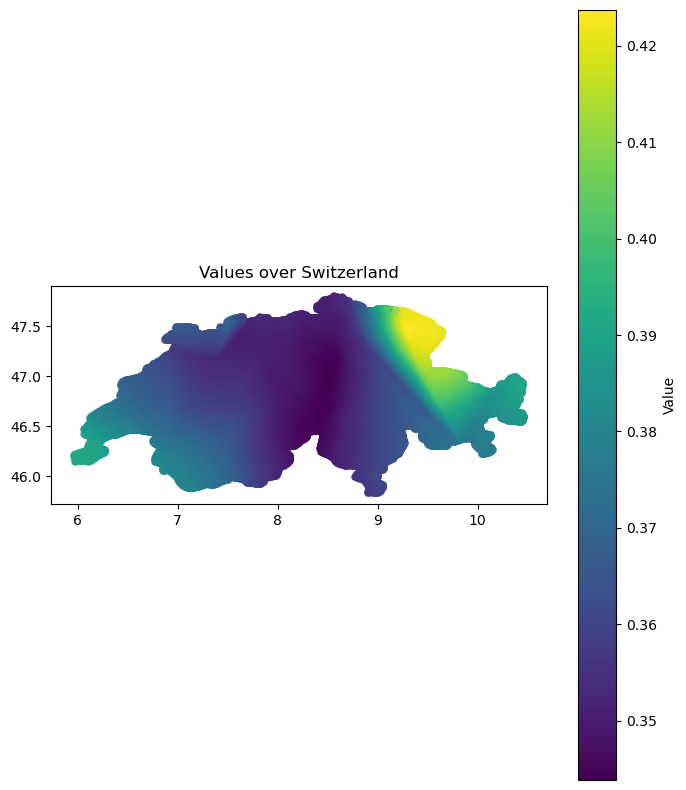

(48831, 2)


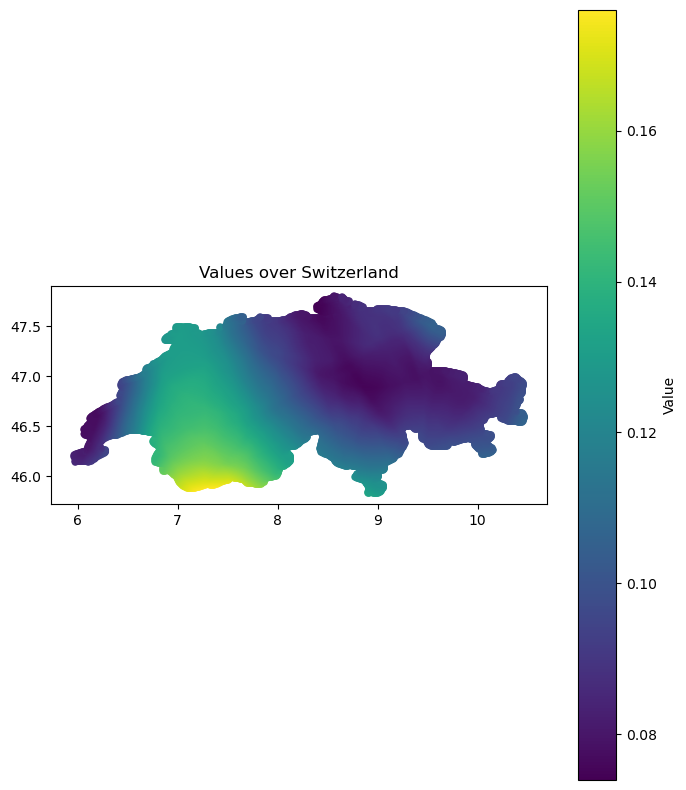

(48831, 2)


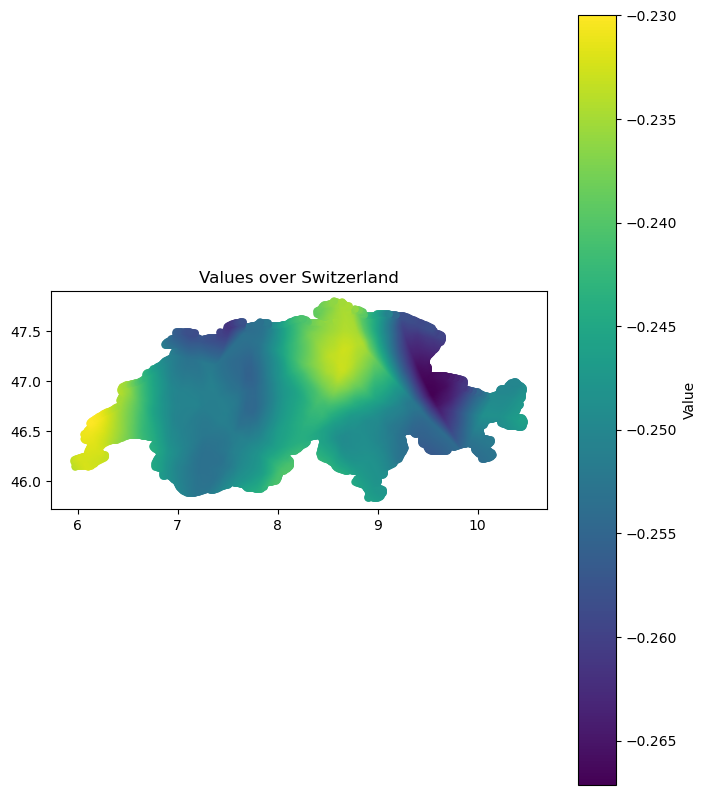

(48831, 2)


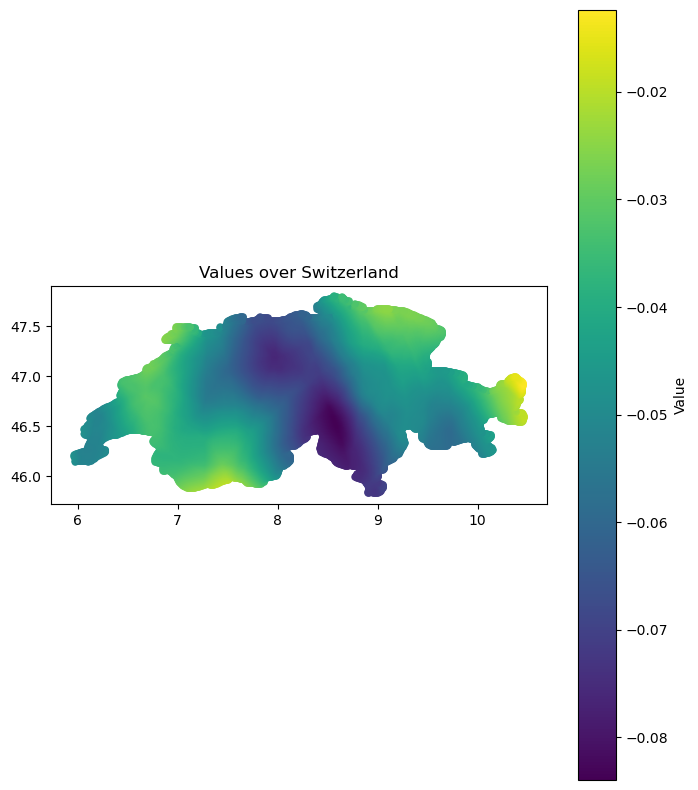

(48831, 2)


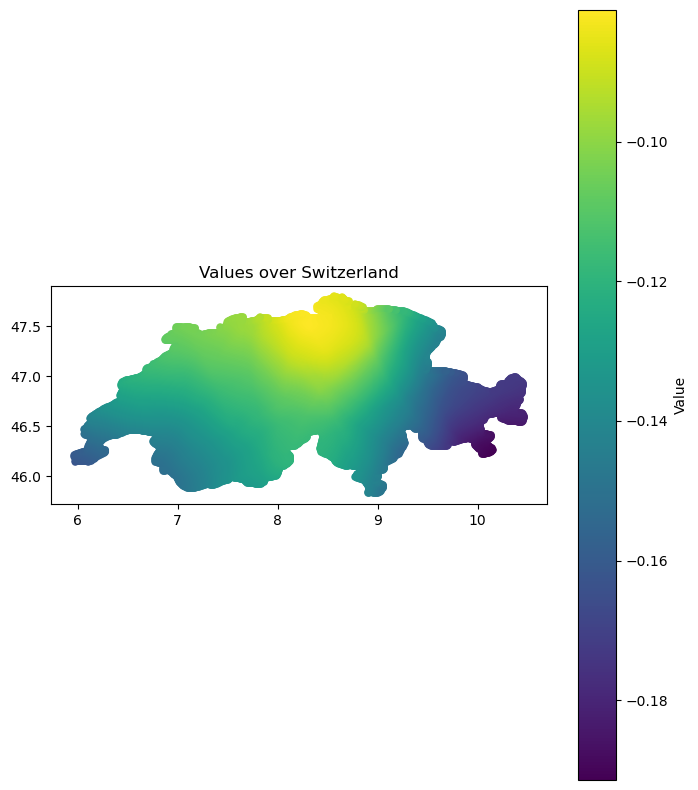

(48831, 2)


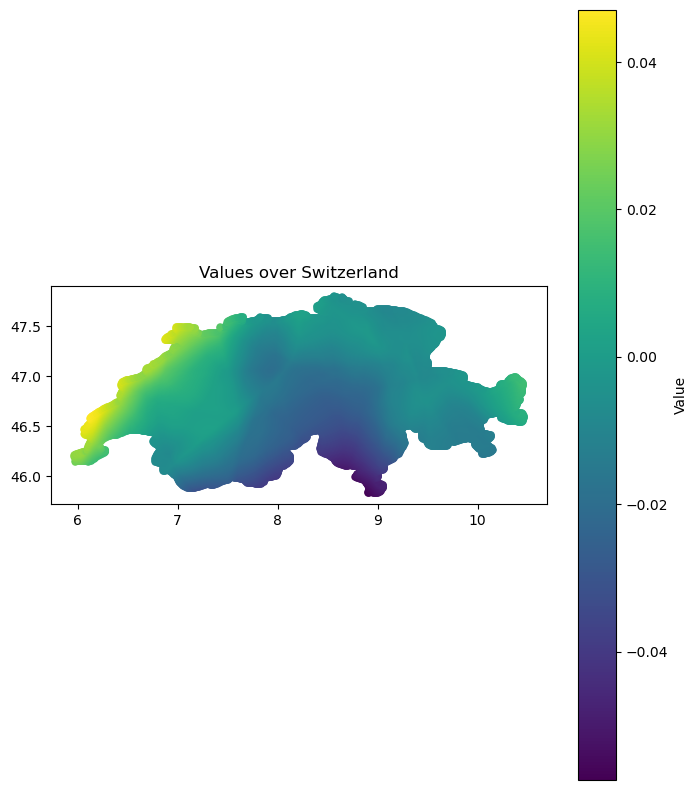

In [3]:
#Plotting the principal components of the embedding vectors
import utils
import importlib
importlib.reload(utils)


for i in range(5):
    utils.plot_country_values("Switzerland", utils.coord_to_PCA, comp_idx=i,grid_resolution=0.01,pos_encoder=pos_enc_DINO,pca_model_path= "PCA_models/PCA_All_comp_full_dataset_Normalized.pkl")
    utils.plot_country_values("Switzerland", utils.coord_to_PCA,comp_idx=i,grid_resolution=0.01,pos_encoder=pos_enc_bioCLIP ,pca_model_path="PCA_models/PCA_All_comp_bioCLIP_Normalized.pkl")
